![alt text](awesome_logo.png "Awesome Retirement Portfolio Projector Tool")

# My Portfolio

In [ ]:
# For data management
import sqlalchemy as sql
import pandas as pd
import os
import datetime
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv

# For Portfolo Optimization
import numpy as np
import pandas as pd
import hvplot.pandas  
from scipy.optimize import minimize, Bounds

# For Simulation
from MCForecastTools import MCSimulation

# Project functions
from awesome_metrics import get_portfolio_allocation_and_valuation, get_annual_expected_return_volatility_and_sharpe_ratio

load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [ ]:
# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

In [44]:
# Get porfolio and report data from user
connection_string = 'sqlite:///awesome_app.db'
engine = sql.create_engine(connection_string, echo=False)

portfolio_df = pd.read_sql_query("SELECT * FROM portfolio", engine)

report_df = pd.read_sql_query("SELECT * FROM report", engine)
[risk_tolerance, years_until_retirement] = report_df.iloc[0]

portfolio_df

,symbol,quantity,type
0,GOOG,10.0,Equity
1,CMG,20.0,Equity
2,IBM,500.0,Equity
3,XLB,1000.0,Equity


In [34]:
print(f"My risk level is {risk_tolerance}.")
print(f"I plan on retiring in {years_until_retirement} years.")

My risk level is high.
I plan on retiring in 20.0 years.


In [35]:
# Tickers for portfolio and recommendation
etf_addition_for_diversification=pd.DataFrame([{"symbol":"SPY", "quantity":0, "type":"Equity"},{"symbol":"AGG", "quantity":0, "type":"Fixed Income"}])
etf_addition_for_diversification

,symbol,quantity,type
0,SPY,0,Equity
1,AGG,0,Fixed Income


In [6]:
#DELETE
# Tickers for portfolio and recommendation
#etf_addition_for_diversification=pd.DataFrame([{"symbol":"SPY", "quantity":0, "type":"Equity"},{"symbol":"AGG", "quantity":0, "type":"Fixed Income"},{ "symbol":"GOOG", "quantity":1, "type":"Equity"}])
#etf_addition_for_diversification

In [36]:
# Portfolio extended for recommendation based on risk profile
portfolio_extended_df=pd.concat([portfolio_df, etf_addition_for_diversification], axis=0)
portfolio_extended_df["Equity"]=portfolio_extended_df["type"]=="Equity"
portfolio_extended_df["Fixed Income"]=portfolio_extended_df["type"]=="Fixed Income"
portfolio_extended_df=portfolio_extended_df.sort_values("symbol",ignore_index=True)
portfolio_extended_df

,symbol,quantity,type,Equity,Fixed Income
0,AGG,0.0,Fixed Income,False,True
1,CMG,20.0,Equity,True,False
2,GOOG,10.0,Equity,True,False
3,IBM,500.0,Equity,True,False
4,SPY,0.0,Equity,True,False
5,XLB,1000.0,Equity,True,False


In [37]:
# Tickers preparation for ALPACA
tickers=portfolio_extended_df["symbol"]
tickers=tickers.drop_duplicates()
tickers

0     AGG
1     CMG
2    GOOG
3     IBM
4     SPY
5     XLB
Name: symbol, dtype: object

In [38]:
# Set the tickers
#tickers = portfolio_df["symbol"]

# Set timeframe to one day ('1D') for the Alpaca API
timeframe = "1D"
# Set the number of years of data to fetch
num_years = 30

# Fetch batches of data from alpaca api to get as miuch hostorical data as possible (up to num_years)
batch_size = 1000
num_days_data_needed = num_years * 365
first_date = datetime.datetime.now()
last_date = first_date - datetime.timedelta(days=num_days_data_needed)

def format_date_iso(date):
    return pd.Timestamp(date, tz="America/New_York").isoformat()

# empty DF to hold alpaca data
portfolio_close_prices_df = pd.DataFrame()


next_batch_date = first_date
while num_days_data_needed > 0:
    end_date = str(next_batch_date).split()[0]
    
    next_batch_date -= datetime.timedelta(days=batch_size)
    if next_batch_date < last_date:
        next_batch_date = last_date

    start_date = str(next_batch_date).split()[0]
    
    results_batch_df = alpaca.get_barset(
        tickers,
        timeframe,
        start = format_date_iso(start_date),
        end = format_date_iso(end_date),
        limit = batch_size
    ).df
    
    results_batch_df.drop(['open', 'high', 'low', 'volume'], level=1, axis=1, inplace=True)

    portfolio_close_prices_df = pd.concat([portfolio_close_prices_df, results_batch_df])
    num_days_data_needed -= batch_size

portfolio_close_prices_df.sort_index(inplace=True)

# Display data
portfolio_close_prices_df

,AGG,CMG,GOOG,IBM,SPY,XLB
,close,close,close,close,close,close
time,,,,,,
2008-01-02 00:00:00-05:00,101.650,146.68,342.590,104.79,144.55,41.33
2008-01-03 00:00:00-05:00,101.720,141.46,342.490,104.94,144.46,41.80
2008-01-04 00:00:00-05:00,102.120,127.12,328.480,101.11,140.93,40.74
2008-01-07 00:00:00-05:00,102.260,123.61,324.340,100.14,141.46,40.25
2008-01-08 00:00:00-05:00,102.510,117.77,315.660,97.39,138.81,39.60
...,...,...,...,...,...,...
2021-08-13 00:00:00-04:00,115.970,1888.44,2769.180,143.20,445.90,86.45
2021-08-16 00:00:00-04:00,116.030,1877.26,2778.670,143.58,447.02,86.02


In [45]:
# Original portfolio addition of allocation
[portfolio_df, original_valuation]=get_portfolio_allocation_and_valuation(portfolio_df, portfolio_close_prices_df[portfolio_df["symbol"]])
portfolio_df=portfolio_df.rename(columns={'Allocation':'Original Allocation'})

print(f"Total portfolio value is ${original_valuation:,.2f}")
display(portfolio_df)

Total portfolio value is $216,589.55


,symbol,quantity,type,price,total,Original Allocation
0,GOOG,10.0,Equity,2730.955,27309.55,0.126089
1,CMG,20.0,Equity,1863.500,37270.00,0.172077
2,IBM,500.0,Equity,137.980,68990.00,0.318529
3,XLB,1000.0,Equity,83.020,83020.00,0.383306


In [42]:
# Portfolio extended addition of allocation
portfolio_extended_df=get_portfolio_allocation_and_valuation(portfolio_extended_df, portfolio_close_prices_df)[0]
portfolio_extended_df=portfolio_extended_df.rename(columns={'Allocation':'Original Allocation'})
display(portfolio_extended_df)


,symbol,quantity,type,Equity,Fixed Income,price,total,Original Allocation
0,AGG,0.0,Fixed Income,False,True,116.145,0.00,0.000000
1,CMG,20.0,Equity,True,False,1863.500,37270.00,0.172077
2,GOOG,10.0,Equity,True,False,2730.955,27309.55,0.126089
3,IBM,500.0,Equity,True,False,137.980,68990.00,0.318529
4,SPY,0.0,Equity,True,False,438.650,0.00,0.000000
5,XLB,1000.0,Equity,True,False,83.020,83020.00,0.383306


<AxesSubplot:title={'center':'Close Prices of Portfolio Assets'}, xlabel='time'>

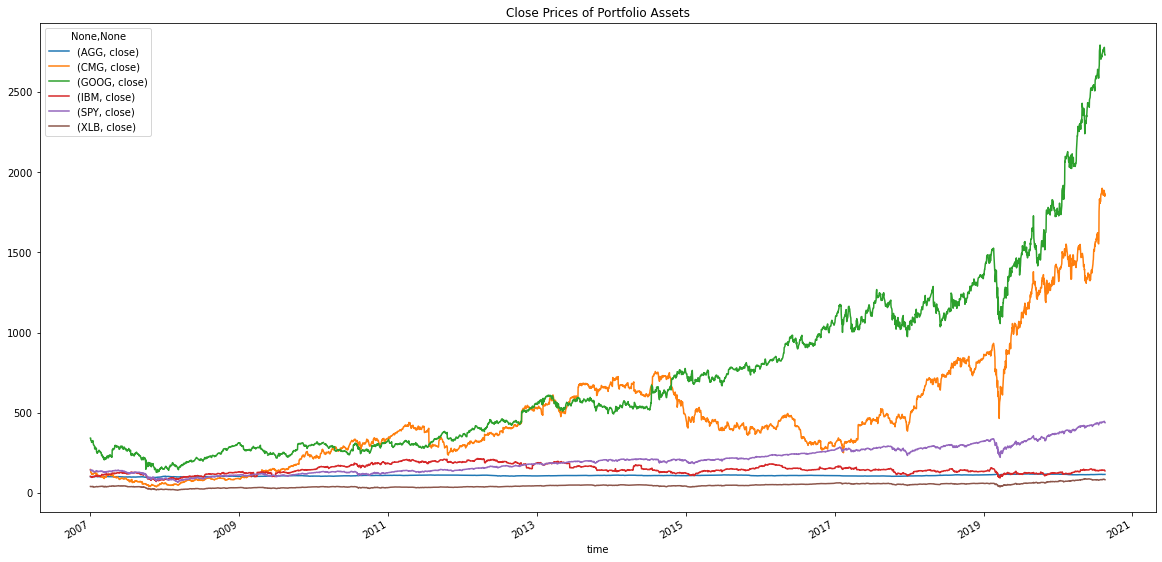

In [46]:
all_close_df = portfolio_close_prices_df.xs('close', axis=1, level=1, drop_level=False)
all_close_df.plot(figsize=[20, 10], title='Close Prices of Portfolio Assets')

---

# Metrics of the portfolio
Daily returns, correlation, covariance



In [47]:
portfolio_close_prices_df.head()

,AGG,CMG,GOOG,IBM,SPY,XLB
,close,close,close,close,close,close
time,,,,,,
2008-01-02 00:00:00-05:00,101.65,146.68,342.59,104.79,144.55,41.33
2008-01-03 00:00:00-05:00,101.72,141.46,342.49,104.94,144.46,41.80
2008-01-04 00:00:00-05:00,102.12,127.12,328.48,101.11,140.93,40.74
2008-01-07 00:00:00-05:00,102.26,123.61,324.34,100.14,141.46,40.25
2008-01-08 00:00:00-05:00,102.51,117.77,315.66,97.39,138.81,39.60


In [48]:
portfolio_daily_returns = portfolio_close_prices_df.pct_change(1).dropna()
portfolio_daily_returns.columns = portfolio_daily_returns.columns.droplevel(1)
portfolio_daily_returns.head()

,AGG,CMG,GOOG,IBM,SPY,XLB
time,,,,,,
2008-01-03 00:00:00-05:00,0.000689,-0.035588,-0.000292,0.001431,-0.000623,0.011372
2008-01-04 00:00:00-05:00,0.003932,-0.101371,-0.040906,-0.036497,-0.024436,-0.025359
2008-01-07 00:00:00-05:00,0.001371,-0.027612,-0.012604,-0.009594,0.003761,-0.012027
2008-01-08 00:00:00-05:00,0.002445,-0.047245,-0.026762,-0.027462,-0.018733,-0.016149
2008-01-09 00:00:00-05:00,-0.002927,0.007897,0.033866,0.009652,0.014192,0.009343


In [49]:
# Calculates correlation of securities in the client_portfolio_close_prices_df
print(f"\033[1m Table of Correlations between Assets")
round(portfolio_daily_returns.corr(),2)

 Table of Correlations between Assets


,AGG,CMG,GOOG,IBM,SPY,XLB
AGG,1.00,-0.01,-0.02,-0.04,-0.08,-0.08
CMG,-0.01,1.00,0.35,0.22,0.46,0.40
GOOG,-0.02,0.35,1.00,0.34,0.62,0.52
IBM,-0.04,0.22,0.34,1.00,0.56,0.51
SPY,-0.08,0.46,0.62,0.56,1.00,0.89
XLB,-0.08,0.40,0.52,0.51,0.89,1.00


# Portfolio Optimization and Recommendation

Optimizes the Sharpe Ratio of a portfolio based on the risk profile of the user.

Level of risk:
1. Aggressive 
2. Moderate
3. Conservative

Use as base a code on: https://examples.pyviz.org/portfolio_optimizer/portfolio.html#portfolio-optimizer-gallery-portfolio
But here we will not use log returns, and we will add two constraints for the portfolio asset allocation based on the risk profile

In [50]:
# set level of risk according to risk profile
level_of_risk=1

In [51]:
#Number of instruments and asset classes
n=len(portfolio_close_prices_df.columns)
portfolio_extended_df=portfolio_extended_df.set_index('symbol')

In [52]:
asset_class_securities=pd.DataFrame({"Equity": np.nan, "Fixed Income":np.nan }, index=portfolio_extended_df.index)
asset_class_securities['Equity']=portfolio_extended_df["Equity"]
portfolio_extended_df

,quantity,type,Equity,Fixed Income,price,total,Original Allocation
symbol,,,,,,,
AGG,0.0,Fixed Income,False,True,116.145,0.00,0.000000
CMG,20.0,Equity,True,False,1863.500,37270.00,0.172077
GOOG,10.0,Equity,True,False,2730.955,27309.55,0.126089
IBM,500.0,Equity,True,False,137.980,68990.00,0.318529
SPY,0.0,Equity,True,False,438.650,0.00,0.000000
XLB,1000.0,Equity,True,False,83.020,83020.00,0.383306


### Functionalize Return and SR operations

In [19]:
#def get_annual_expected_return_volatility_and_sharpe_ratio(portfolio_weights):
    """
#    Takes in portfolio_weights, returns array or annualized expected return, volatility, sharpe ratio
    """
 #   portfolio_weights = np.array(portfolio_weights)
    
    #Annual expected return by the weighted average of the historical average of daily returns of each security, multiplied by 252
 #   expected_annual_return = np.sum(portfolio_daily_returns.mean() * portfolio_weights) * 252
    
    # Annual Portfolio Variance = w.T * Covariance * w    (where "*" represents here the matrix multiplication) OBS: Var_annual = Var_daily * 252
    # np.dot function does a matrix multiplication. Another alternative is np.matmul
 #   portfolio_variance = np.dot( portfolio_weights.T,   np.dot(   portfolio_daily_returns.cov() * 252, portfolio_weights   ))
 #   portfolio_volatility = np.sqrt(portfolio_variance)

    #Sharpe Ratio (annual) (Assumed risk_free_rate=0)
 #   risk_free_rate_annualized=0
 #   sharpe_ratio = (expected_annual_return - risk_free_rate_annualized)/portfolio_volatility
    
 #   return np.array([expected_annual_return,portfolio_volatility,sharpe_ratio]) 

To fully understand all the parameters, check out:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

In [20]:
#help(minimize)

In [53]:
# Function to be optimized 
# Optimization works with a minimization function, so instead of maximizing Sharpe Ratio, we will minimize the negative sharpe.
def negative_sharpe_ratio(portfolio_weights, portfolio_daily_returns):
    return  get_annual_expected_return_volatility_and_sharpe_ratio(portfolio_weights)[2] * -1

In [54]:
# Determination of the limits for total equity allocation given level of risk
# Here we defined the required arguments for optimization constraints
if level_of_risk==1:
    [equity_lower_limit, equity_upper_limit]  =[0.75, 0.90]

elif level_of_risk==2:
    [equity_lower_limit, equity_upper_limit]  =[0.4, 0.6]

elif level_of_risk==3:
    [equity_lower_limit, equity_upper_limit]  =[0.05 , 0.2]

else: [equity_lower_limit, equity_upper_limit]=[0 , 1]


In [55]:
# Contraints: weight sum must be equal to 1 
def check_sum_of_portfolio_weights_is_one(portfolio_weights):
    '''
    Returns 0 if sum of portfolio_weights is 1.0
    '''
    return np.sum(portfolio_weights) - 1

In [56]:
# Constraint: equity allocation is less than maximum limit (inequality constraint, upper limit - equity allocation >0)
def check_sum_of_portfolio_equity_weights_is_less_than_upper_bound(portfolio_weights, asset_class_securities, equity_upper_limit):
    """
    Makes sure allocation in equity is less than the maximum allowed
    """
    portfolio_equity_allocation=sum(portfolio_weights * asset_class_securities['Equity'])
    return  equity_upper_limit - portfolio_equity_allocation

In [57]:
# Constraint: equity allocation is more than minimum limit (inequality constraint, equity allocation - lower_limit >0)
def check_sum_of_portfolio_equity_weights_is_more_than_lower_bound(portfolio_weights,asset_class_securities , equity_lower_limit):
    """
    Makes sure allocation in equity is more than the minimum allowed
    """
    portfolio_equity_allocation=sum(portfolio_weights * asset_class_securities['Equity'])
    return portfolio_equity_allocation - equity_lower_limit

In [58]:
"""
DEFINITION OF CONSTRAINTS
By convention of minimize function it should be a function that returns zero for equality constraints, and a positive number for inequality constraints. 
Constraint type: 'eq' for equality, 'ineq' for inequality. 
'fun': The function defining the constraint:      
                              sum(portfolio_weights)=1  ==> sum(portfolio_weights) - 1 = 0
       portfolio_equity_allocation < equity_upper_limit ==> equity_upper_limit - portfolio_equity_allocation >0
       portfolio_equity allocation > equity_lower_limit ==> portfolio_equity_allocation - lower_limit >0
""" 
cons = [{'type':'eq','fun'  :check_sum_of_portfolio_weights_is_one},
        {'type':'ineq','fun':check_sum_of_portfolio_equity_weights_is_less_than_upper_bound,'args':(asset_class_securities, equity_upper_limit)},
        {'type':'ineq','fun':check_sum_of_portfolio_equity_weights_is_more_than_lower_bound,'args':(asset_class_securities, equity_lower_limit)}]

In [59]:
# Setting bounds for the weights of each security
# Only long positions are allowed
lb=[0]*n
ub=[1]*n
        
bounds=Bounds(lb, ub)
bounds

Bounds([0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1])

In [60]:
# Initial Guess (equal distribution)
# n: number of stocks in the portfolio to optimize
initial_guess = [1/n]*n
initial_guess


[0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666]

In [61]:
# OPTIMIZATION 
# Sequential Least SQuares Programming (SLSQP) method is used, which is similar to Least Square optimization, but using less resources.
optimization_results = minimize(negative_sharpe_ratio, initial_guess, args=(portfolio_daily_returns), method='SLSQP', bounds=bounds, constraints=cons)

In [62]:
# Optimization success
print(optimization_results.message)
print(f"optimized Sharpe ratio: {-optimization_results.fun:.2f}" )

Optimization terminated successfully
optimized Sharpe ratio: 0.81


In [63]:
# Optimal allocation (weights)
optimal_portfolio_weights = optimization_results.x

#Formatting results
portfolio_position_names=pd.Series(portfolio_daily_returns.columns)
optimal_portfolio_weights=pd.Series(optimal_portfolio_weights)
optimal_portfolio_weights=pd.concat([portfolio_position_names,optimal_portfolio_weights], axis=1)
optimal_portfolio_weights.columns=["symbol","Optimal Allocation"]
optimal_portfolio_weights=optimal_portfolio_weights.set_index("symbol")

#Printout results
print(f" User risk profile: {risk_tolerance} risk")
optimal_portfolio_weights_in_percentages=round(optimal_portfolio_weights*100,2)
optimal_portfolio_weights_in_percentages

 User risk profile: high risk


,Optimal Allocation
symbol,
AGG,25.00
CMG,35.68
GOOG,39.32
IBM,0.00
SPY,0.00
XLB,0.00


In [64]:
portfolio_allocation_comparison=pd.concat([portfolio_extended_df["type"],round(portfolio_extended_df["Original Allocation"]*100,2),\
                                           optimal_portfolio_weights_in_percentages ], axis=1)
portfolio_allocation_comparison

,type,Original Allocation,Optimal Allocation
symbol,,,
AGG,Fixed Income,0.00,25.00
CMG,Equity,17.21,35.68
GOOG,Equity,12.61,39.32
IBM,Equity,31.85,0.00
SPY,Equity,0.00,0.00
XLB,Equity,38.33,0.00


In [65]:
portfolio_allocation_comparison.hvplot.bar(
    title="Allocation Comparison between Original and Optimized Portfolio (%)"
    ,ylabel="Security Allocation (%)"
    ,xlabel="Security Symbol"
    ,rot=90
    ,value_label="Allocation (%)"
    ,height=500
)

:Bars   [symbol,Variable]   (Allocation (%))

In [66]:
# Optimal values (Max Sharpe ratio point)
[optimal_expected_return, optimal_volatility, maximum_Sharpe_ratio]= get_annual_expected_return_volatility_and_sharpe_ratio(optimization_results.x)

print( f"Optimal Annual Expected Return: {100*optimal_expected_return:.2f}%"  )
print( f"Optimal Annual Volatility:      {100*optimal_volatility:.2f}%") 
print( f"Maximum Annual Sharpe ratio:    {maximum_Sharpe_ratio:.2f}")


Optimal Annual Expected Return: 17.64%
Optimal Annual Volatility:      21.88%
Maximum Annual Sharpe ratio:    0.81


In [67]:
# Return of results 
# ORIGINAL PORTFOLIO Performance Metrics
[original_expected_return, original_volatility, original_Sharpe_ratio]=get_annual_expected_return_volatility_and_sharpe_ratio\
        (np.array(portfolio_extended_df['Original Allocation']))

print( f"Original Annual Expected Return:  {100*original_expected_return:.2f} %"  )
print( f"Original Annual Volatility:       {100*original_volatility:.2f} % ") 
print( f"Original Annual Sharpe ratio:     {original_Sharpe_ratio:.2f}")
round(portfolio_extended_df,2)

Original Annual Expected Return:  12.31 %
Original Annual Volatility:       22.44 % 
Original Annual Sharpe ratio:     0.55


,quantity,type,Equity,Fixed Income,price,total,Original Allocation
symbol,,,,,,,
AGG,0.0,Fixed Income,False,True,116.14,0.00,0.00
CMG,20.0,Equity,True,False,1863.50,37270.00,0.17
GOOG,10.0,Equity,True,False,2730.96,27309.55,0.13
IBM,500.0,Equity,True,False,137.98,68990.00,0.32
SPY,0.0,Equity,True,False,438.65,0.00,0.00
XLB,1000.0,Equity,True,False,83.02,83020.00,0.38


In [ ]:
# HERE TO INPUT GRAPH THAT COMPARES ORIGINAL VERSUS OPTIMAL RETURN, VOLATILITY AND SHARPE RATIO

# MONTECARLO SIMULATION

In [68]:
report_df

,risk_tolerance,years_until_retirement
0,high,20.0


In [69]:
MC_n_years_new_allocation_original=MCSimulation(
    portfolio_data=portfolio_close_prices_df
    ,weights=list(portfolio_extended_df['Original Allocation'])
    ,num_simulation=500
    ,num_trading_days=252*int(report_df['years_until_retirement'][0])
)

In [70]:
MC_n_years_new_allocation_original.portfolio_data.head()

AGG                  CMG                 GOOG  \
                            close daily_return   close daily_return   close   
time                                                                          
2008-01-02 00:00:00-05:00  101.65          NaN  146.68          NaN  342.59   
2008-01-03 00:00:00-05:00  101.72     0.000689  141.46    -0.035588  342.49   
2008-01-04 00:00:00-05:00  102.12     0.003932  127.12    -0.101371  328.48   
2008-01-07 00:00:00-05:00  102.26     0.001371  123.61    -0.027612  324.34   
2008-01-08 00:00:00-05:00  102.51     0.002445  117.77    -0.047245  315.66   

                                           IBM                  SPY  \
                          daily_return   close daily_return   close   
time                                                                  
2008-01-02 00:00:00-05:00          NaN  104.79          NaN  144.55   
2008-01-03 00:00:00-05:00    -0.000292  104.94     0.001431  144.46   
2008-01-04 00:00:00-05:00    -0.040906  101.11    -0.036497  140.93   
2008-01-07 00:00:00-05:00    -0.012604  100.14    -0.009594  141.46   
2008-01-08 00:00:00-05:00    -0.026762   97.39    -0.027462  138.81   

                                          XLB               
                          daily_return  close daily_return  
time                                                        
2008-01-02 00:00:00-05:00          NaN  41.33          NaN  
2008-01-03 00:00:00-05:00    -0.000623  41.80     0.011372  
2008-01-04 00:00:00-05:00    -0.024436  40.74    -0.025359  
2008-01-07 00:00:00-05:00     0.003761  40.25    -0.012027  
2008-01-08 00:00:00-05:00    -0.018733  39.60    -0.016149

In [ ]:
MC_n_years_new_allocation_original.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.


In [ ]:
MC_n_years_new_allocation_original.plot_distribution()

In [ ]:
MC_n_years_new_allocation_original.summarize_cumulative_return()

In [ ]:
MC_n_years_new_allocation_original.plot_simulation();

In [ ]:
# Optimized Portfolio Montecarlo Simulation
MC_n_years_optimized=MCSimulation(
    portfolio_data=portfolio_close_prices_df
    ,weights=list(optimal_portfolio_weights["Optimal Allocation"])
    ,num_simulation=500
    ,num_trading_days=252*int(report_df['years_until_retirement'][0])
)

In [ ]:
MC_n_years_optimized.portfolio_data.head()

In [ ]:
MC_n_years_optimized.calc_cumulative_return()

In [ ]:
MC_n_years_optimized.plot_distribution() 

In [ ]:
MC_n_years_optimized.plot_simulation()

In [ ]:
MC_n_years_optimized.summarize_cumulative_return()

In [ ]:
#Summary statistics result comparison
summary_statistics_combined=pd.concat([MC_n_years_new_allocation_original.summarize_cumulative_return(),MC_n_years_optimized.summarize_cumulative_return()]
          , axis=1)

summary_statistics_combined.columns=["Original","Optimized"]
round(summary_statistics_combined ,2)    

In [ ]:
# Calculating expected future amount
initial_investment=total_portfolio_value
final_investment=summary_statistics_combined.iloc[1:10,:]*initial_investment

# Apply money 
final_investment['Original']=final_investment['Original'].apply(lambda x: "${:,.0f}k".format(x/1000))
final_investment['Optimized']=final_investment['Optimized'].apply(lambda x: "${:,.0f}k".format(x/1000))
final_investment

# Future improvements: 
* Optimization: option to decrease variance, but keep original expected return.
* Montecarlo Simulation: include option for periodic contributions